# Dog Memorizer GAN


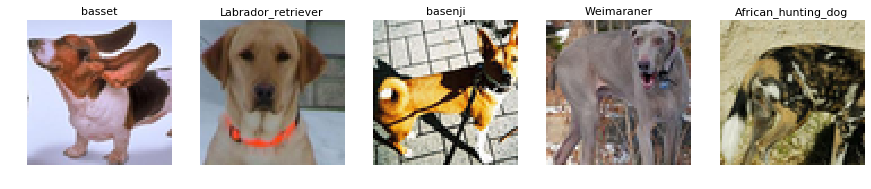

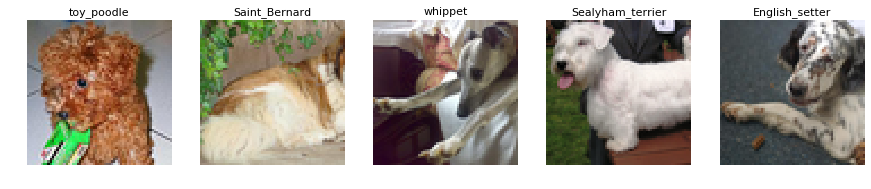

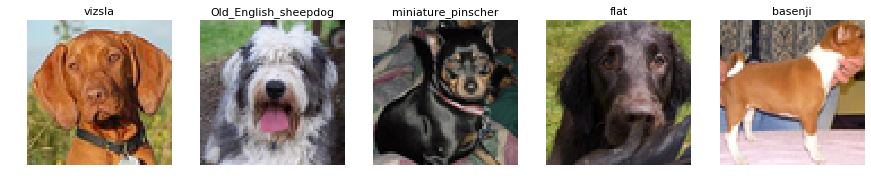

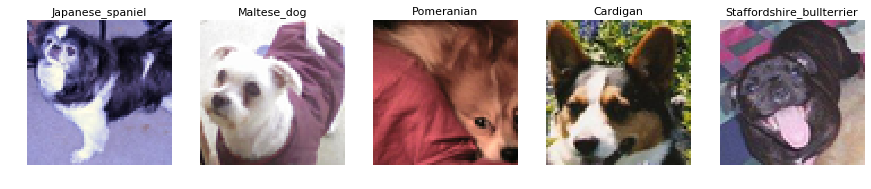

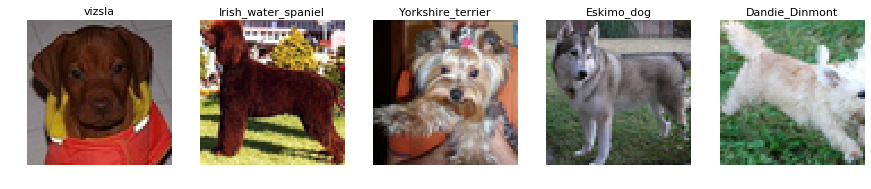

In [1]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '../input/generative-dog-images/'
if not ComputeLB: ROOT = '../input/'
IMAGES = os.listdir(ROOT + 'all-dogs/all-dogs/')
breeds = os.listdir(ROOT + 'annotation/Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'annotation/Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'annotation/Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20579),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/all-dogs/' + IMAGES[x[k]])
        w = img.size[0]
        h = img.size[1]
        sz = np.min((w,h))
        a=0; b=0
        if w<h: b = (h-sz)//2
        else: a = (w-sz)//2
        img = img.crop((0+a, 0+b, sz+a, sz+b))  
        img = img.resize((64,64), Image.ANTIALIAS)   
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

# Build Discriminator

In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Reshape, Flatten, concatenate, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [3]:
# BUILD DISCRIMINATIVE NETWORK
dog = Input((12288,))
dogName = Input((10000,))
x = Dense(12288, activation='sigmoid')(dogName) 
x = Reshape((2,12288,1))(concatenate([dog,x]))
x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
discriminated = Flatten()(x)

# COMPILE
discriminator = Model([dog,dogName], discriminated)
discriminator.get_layer('conv').trainable = False
discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12288)        122892288   input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24576)        0           input_1[0][0]                    
                                                                 dense_1[0][0]                    
__________

# Train Discriminator
We will train the Discriminator to memorize the training images. (Typically you don't train the Discriminator ahead of time. The D learns as the G learns. But this GAN is special).

In [4]:
# TRAINING DATA
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORK
lr = 0.5
for k in range(5):
    annealer = LearningRateScheduler(lambda x: lr)
    h = discriminator.fit([zeros,train_X], train_y, epochs = 10, batch_size=256, callbacks=[annealer], verbose=0)
    print('Epoch',(k+1)*10,'/30 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /30 - loss = 0.5520164541244507
Epoch 20 /30 - loss = 0.5345397928237915
Epoch 30 /30 - loss = 0.5325692771911621
Epoch 40 /30 - loss = 0.5323772935867309
Epoch 50 /30 - loss = 0.5322671385765075


# Delete Training Images
Our Discriminator has memorized all the training images. We will now delete the training images. Our Generator will never see the training images. It will only be coached by the Discriminator. Below are examples of images that the Discriminator memorized.

In [5]:
del train_X, train_y, imagesIn

Discriminator Recalls from Memory Dogs


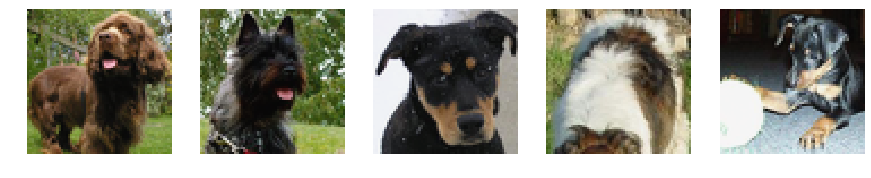

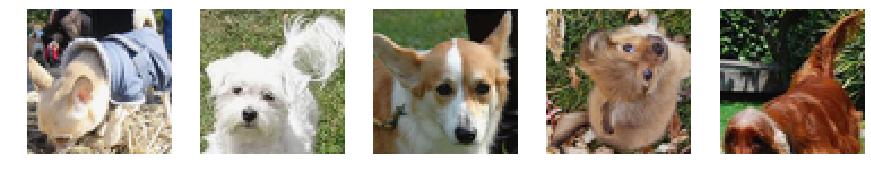

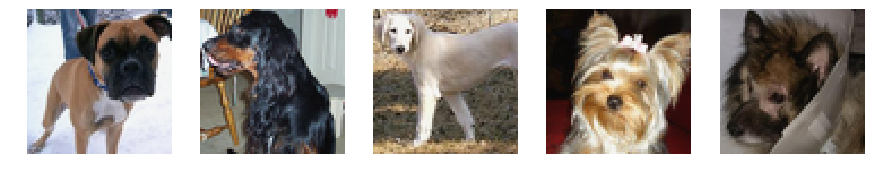

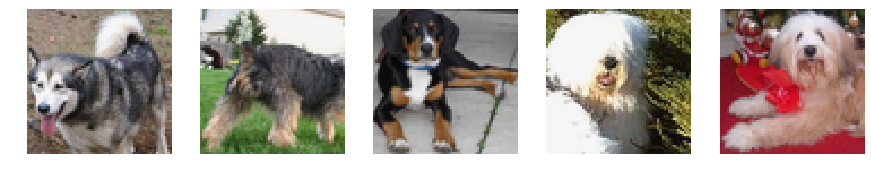

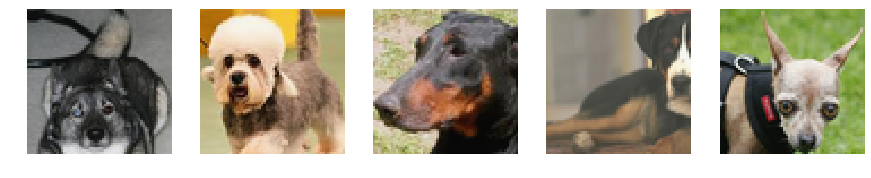

In [6]:
print('Discriminator Recalls from Memory Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = discriminator.predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,10000))]).reshape((-1,64,64,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Build Generator and GAN
We will purposely give our Generator a bottleneck in its memory. Using poor memory forces the Generator to learn a generalization of images and not memorize the images exactly.

In [7]:
# BUILD GENERATOR NETWORK
BadMemory = True

if BadMemory:
    seed = Input((10000,))
    x = Dense(2048, activation='elu')(seed)
    x = Reshape((8,8,32))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='linear', padding='same')(x)
    generated = Flatten()(x)
else:
    seed = Input((10000,))
    generated = Dense(12288, activation='linear')(seed)

# COMPILE
generator = Model(seed, [generated,Reshape((10000,))(seed)])

# DISPLAY ARCHITECTURE
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         20482048    input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 8, 8, 32)     0           dense_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 128)    36992       reshape_2[0][0]                  
__________________________________________________________________________________________________
up_samplin

In [8]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
discriminator.trainable=False    
gan_input = Input(shape=(10000,))
x = generator(gan_input)
gan_output = discriminator(x)

# COMPILE GAN
gan = Model(gan_input, gan_output)
gan.get_layer('model_1').get_layer('conv').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 12288), (Non 20612163    input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        122892290   model_2[1][0]                    
                                                                 model_2[1][1]                    
Total params: 143,504,453
Trainable params: 20,612,163
Non-trainable params: 122,892,290
__________________________________________________________________________________________________


# Discriminator Coaches Generator
In a typical GAN, the discriminator does not memorize the training images beforehand. Instead it learns to distinquish real images from fake images at the same time that the Generator learns to make fake images. In this GAN, we taught the Discriminator ahead of time and it will now teach the Generator.

Epoch 1 /50 - loss = 6612.52940859375


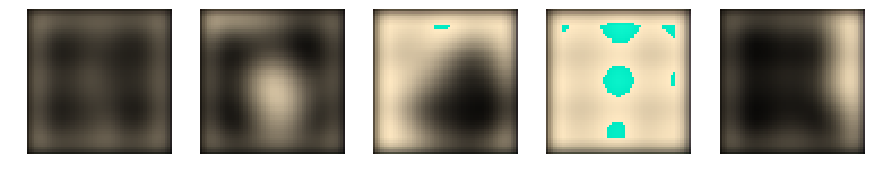

Epoch 2 /50 - loss = 2160.8714001953126


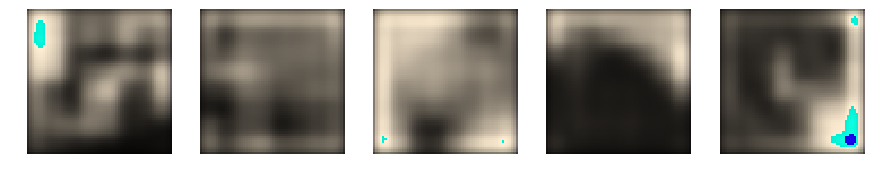

Epoch 3 /50 - loss = 1212.281583984375


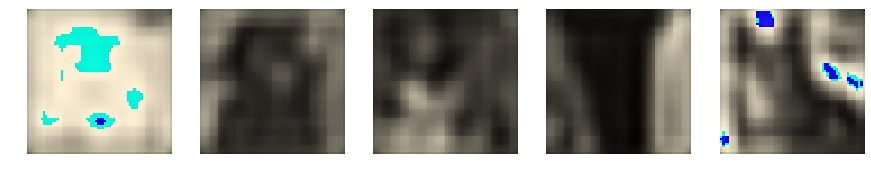

Epoch 4 /50 - loss = 902.806588671875


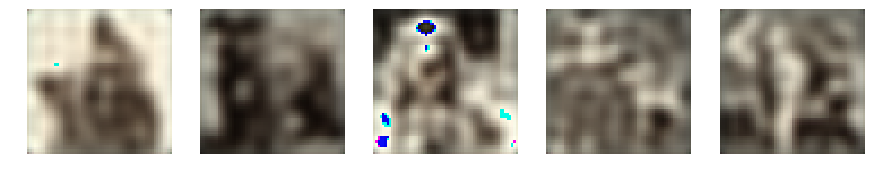

Epoch 5 /50 - loss = 809.52934765625


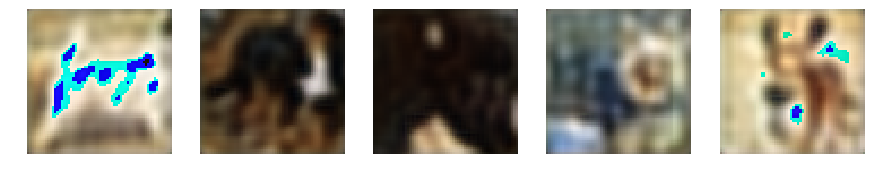

Epoch 6 /50 - loss = 421.0837649902344


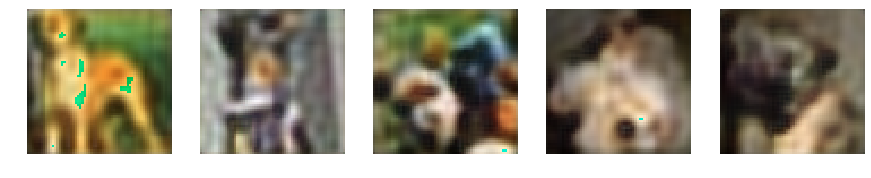

Epoch 7 /50 - loss = 288.4542240722656


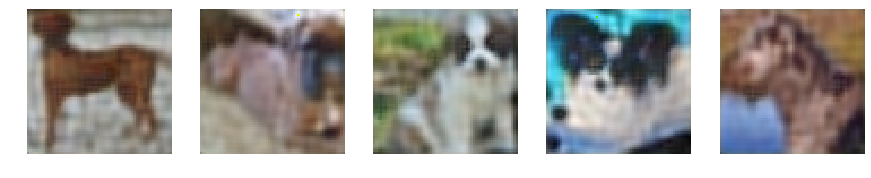

Epoch 8 /50 - loss = 195.4312832763672


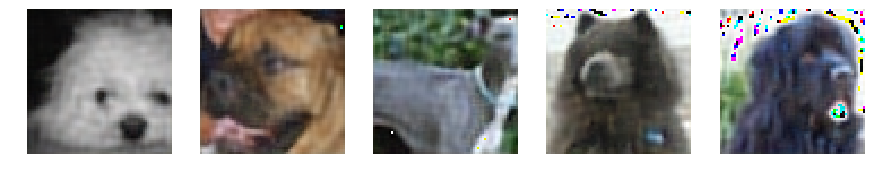

Epoch 9 /50 - loss = 136.075158203125


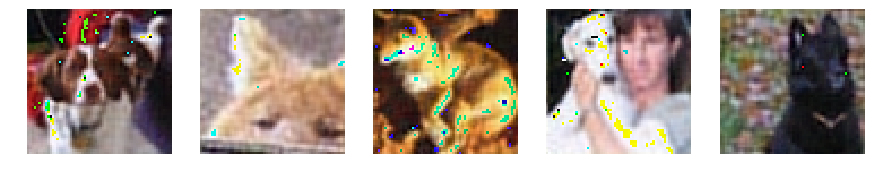

Epoch 10 /50 - loss = 112.95421798095703


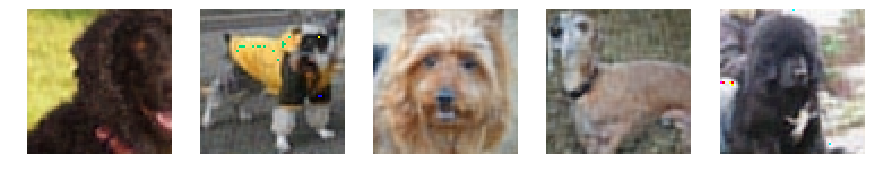

Epoch 11 /50 - loss = 98.23053426513673


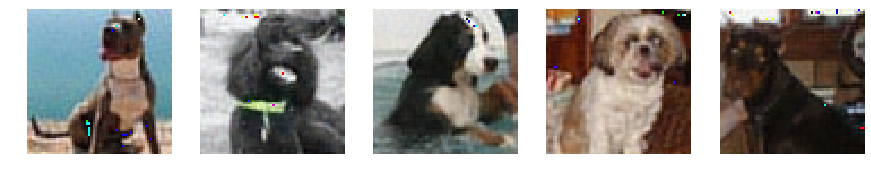

Epoch 12 /50 - loss = 91.458192578125


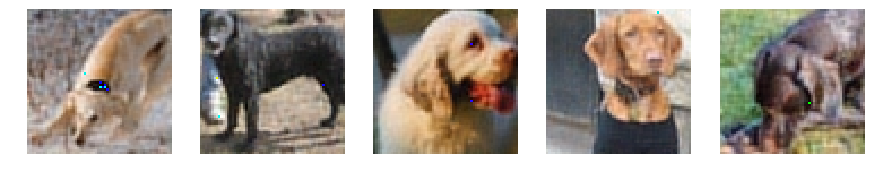

Epoch 13 /50 - loss = 83.50515268554688


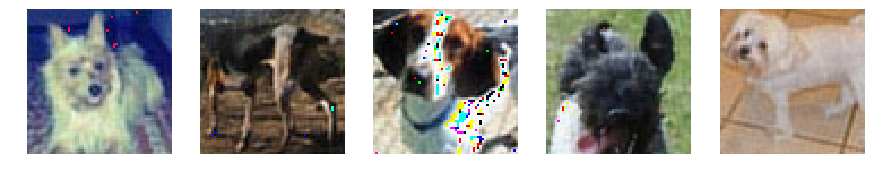

Epoch 14 /50 - loss = 81.29313232421875


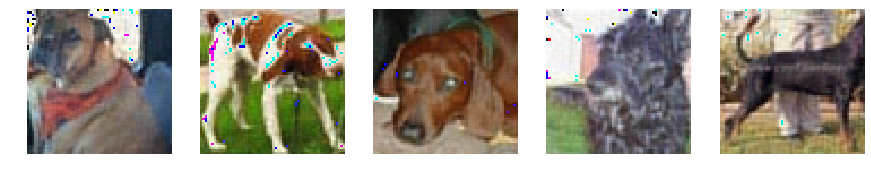

Epoch 15 /50 - loss = 78.33455904541016


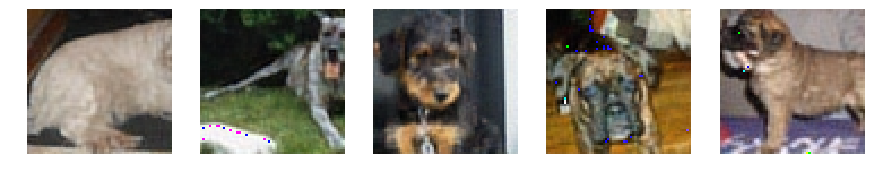

Epoch 16 /50 - loss = 76.19331762695313


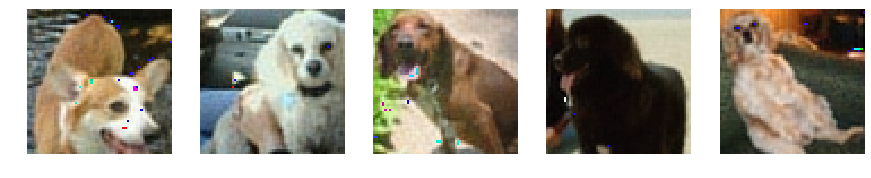

Epoch 17 /50 - loss = 73.42123266601563


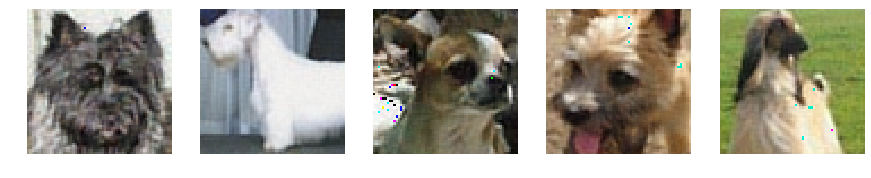

Epoch 18 /50 - loss = 74.898688671875


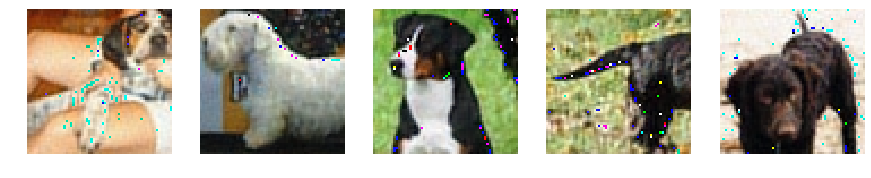

Epoch 19 /50 - loss = 73.28979802246094


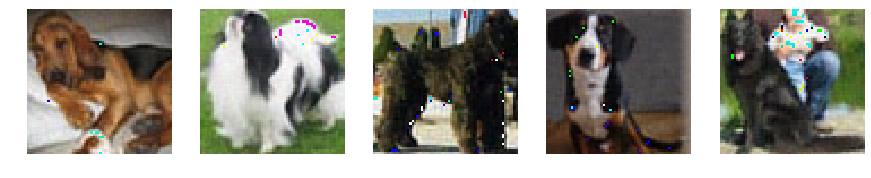

Epoch 20 /50 - loss = 71.27948111572266


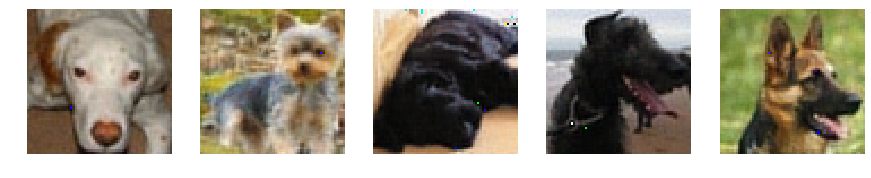

Epoch 21 /50 - loss = 70.50309932861329


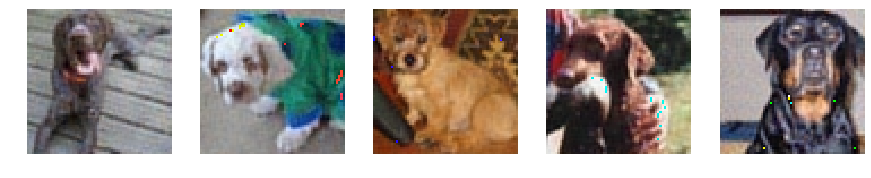

Epoch 22 /50 - loss = 73.0469344116211


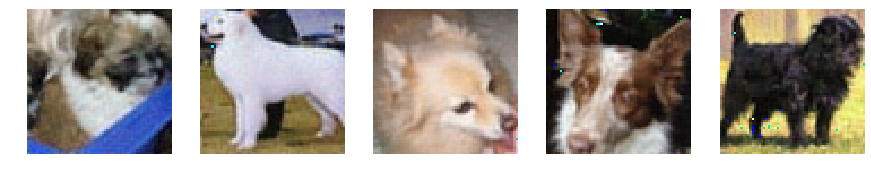

Epoch 23 /50 - loss = 69.41994921875


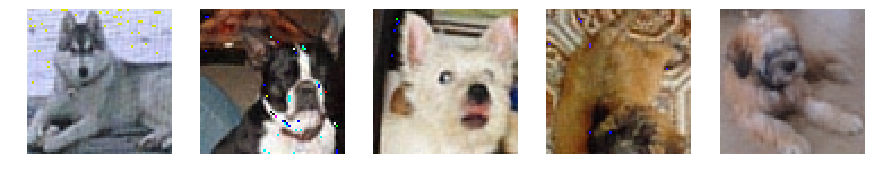

Epoch 24 /50 - loss = 68.85259198608398


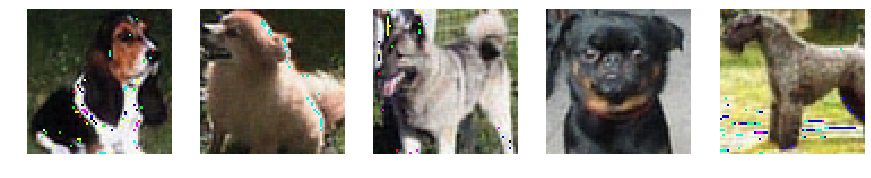

Epoch 25 /50 - loss = 69.15482779541016


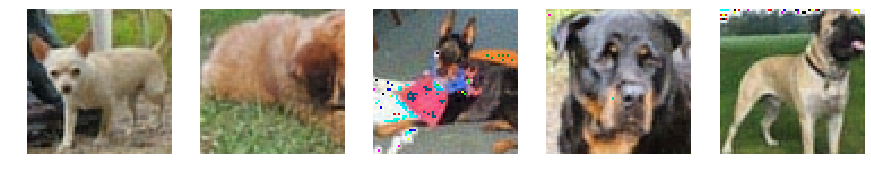

Epoch 26 /50 - loss = 69.62057521972656


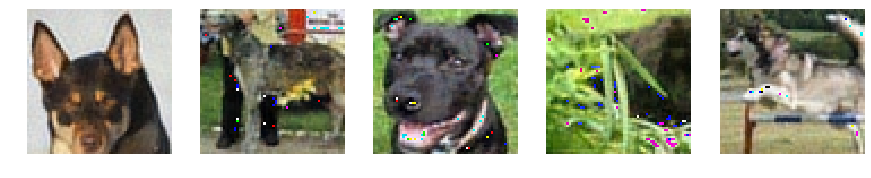

Epoch 27 /50 - loss = 68.20797790527344


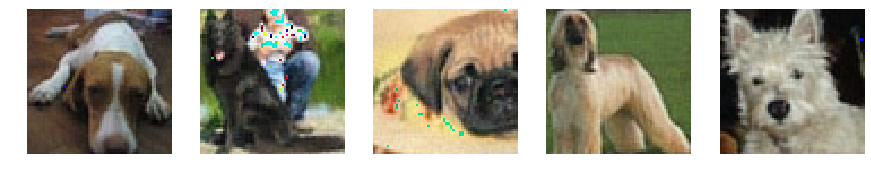

Epoch 28 /50 - loss = 67.58167126464843


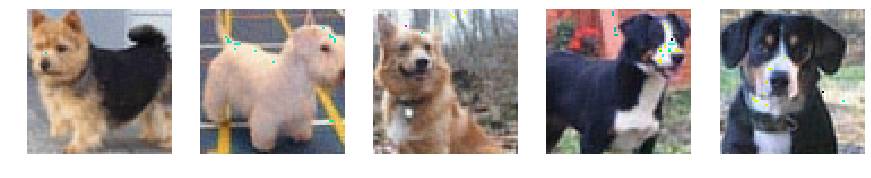

Epoch 29 /50 - loss = 67.28626138916016


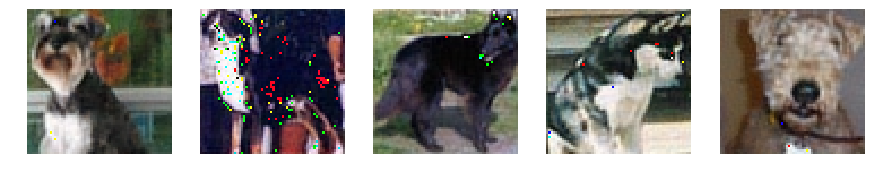

Epoch 30 /50 - loss = 66.55340131835938


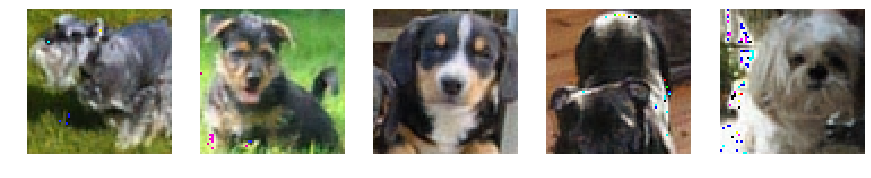

Epoch 31 /50 - loss = 66.53578001708985


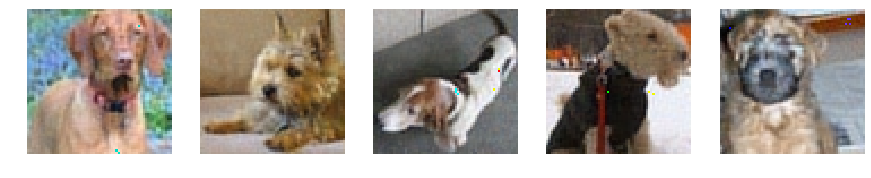

Epoch 32 /50 - loss = 66.6645802734375


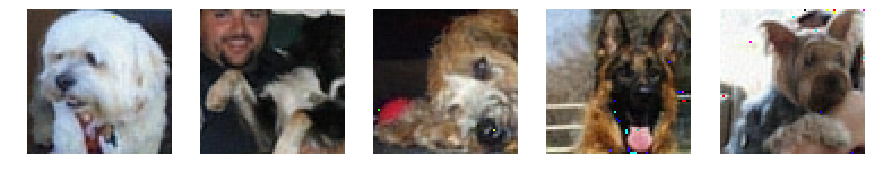

Epoch 33 /50 - loss = 66.57477336425781


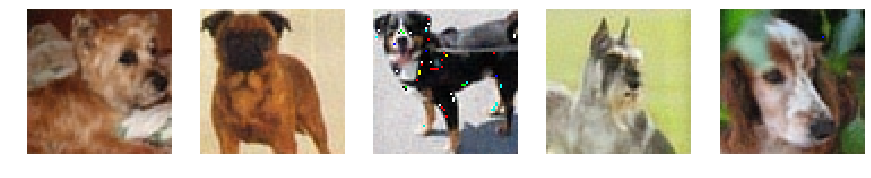

Epoch 34 /50 - loss = 66.07455027465821


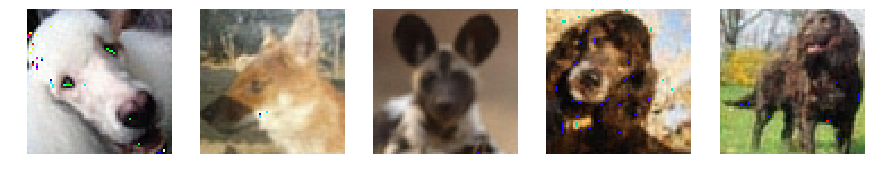

Epoch 35 /50 - loss = 66.2628816772461


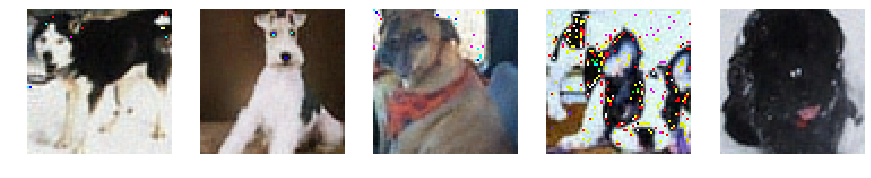

Epoch 36 /50 - loss = 66.18367666015625


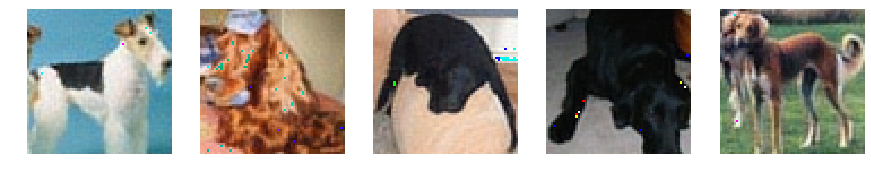

Epoch 37 /50 - loss = 65.45381822509766


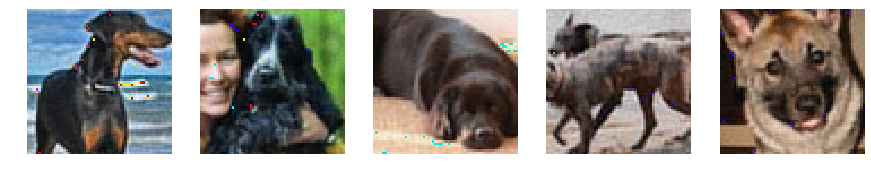

Epoch 38 /50 - loss = 64.90126169433594


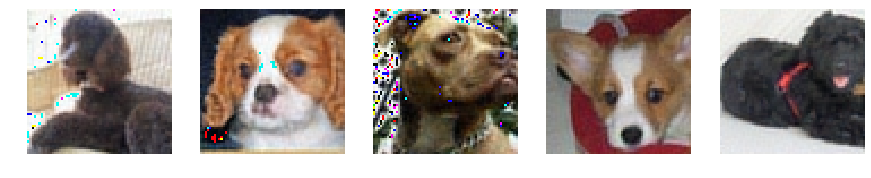

Epoch 39 /50 - loss = 64.8424476196289


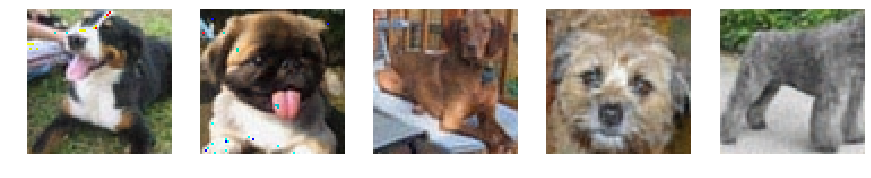

Epoch 40 /50 - loss = 64.33867163085938


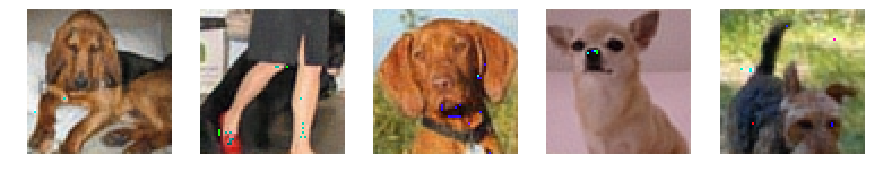

Epoch 41 /50 - loss = 64.64816086425782


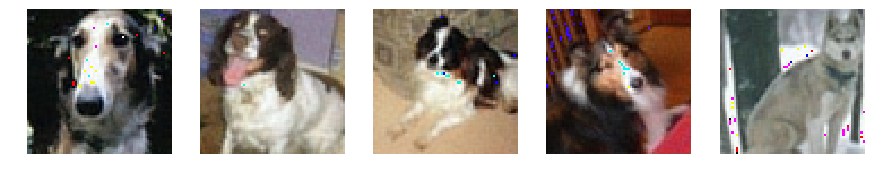

Epoch 42 /50 - loss = 64.65070791625976


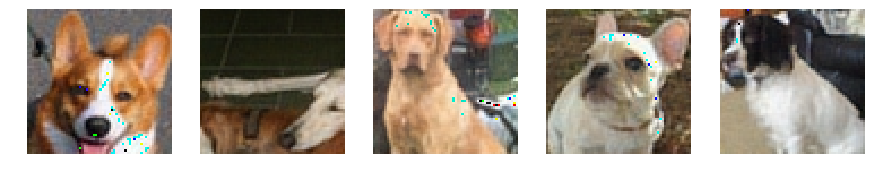

Epoch 43 /50 - loss = 63.99463742675781


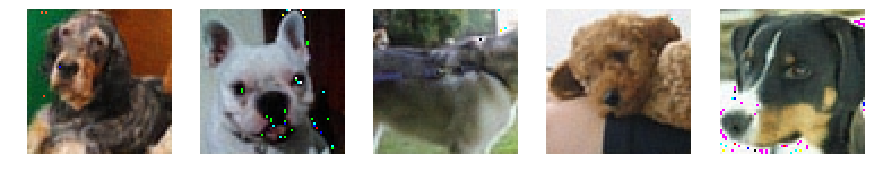

Epoch 44 /50 - loss = 64.05300487060546


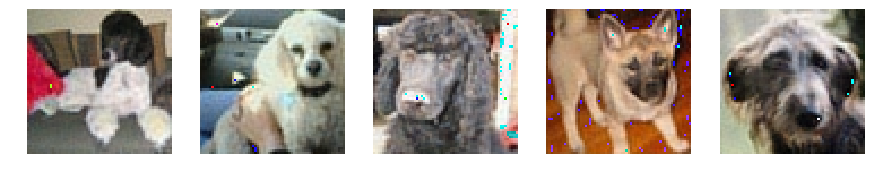

Epoch 45 /50 - loss = 64.44792861328125


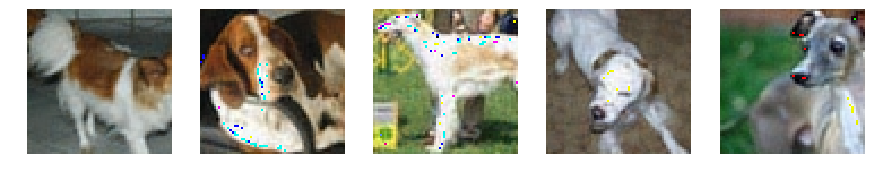

Epoch 46 /50 - loss = 63.606619885253906


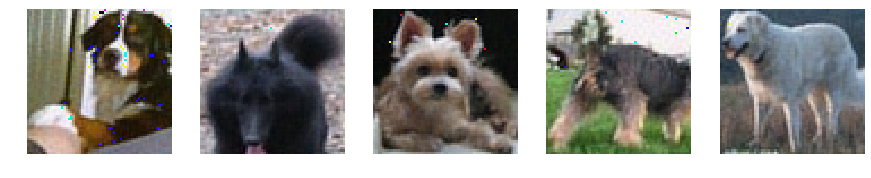

Epoch 47 /50 - loss = 63.98926844482422


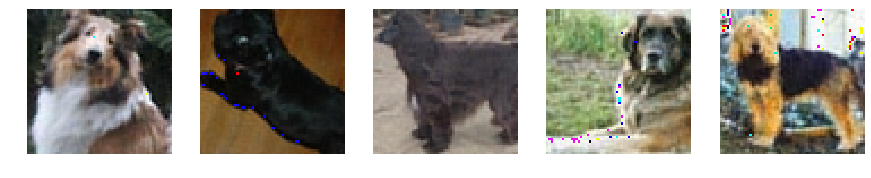

Epoch 48 /50 - loss = 65.57689221191406


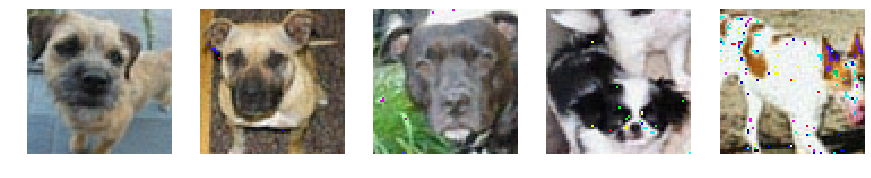

Epoch 49 /50 - loss = 63.91521677246094


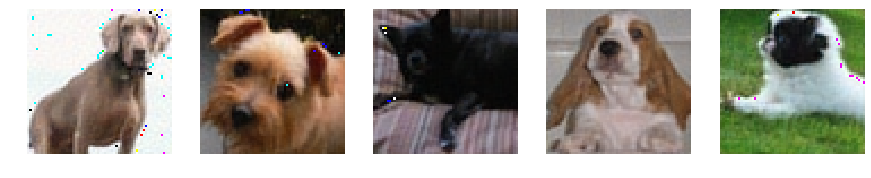

Epoch 50 /50 - loss = 63.14693460693359


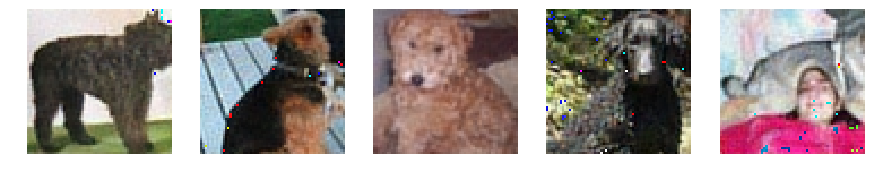

In [9]:
# TRAINING DATA
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORKS
ep = 1; it = 50
if BadMemory: lr = 0.005
else: lr = 5.
    
for k in range(it):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR
    annealer = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = ep, batch_size=256, callbacks=[annealer], verbose=0)

    # DISPLAY GENERATOR LEARNING PROGRESS 
    print('Epoch',(k+1),'/'+str(it)+' - loss =',h.history['loss'][-1] )
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = generator.predict(xx.reshape((-1,10000)))[0].reshape((-1,64,64,3))
        img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()  
            
    # ADJUST LEARNING RATES
    if BadMemory:
        ep *= 2
        if ep>=32: lr = 0.001
        if ep>256: ep = 256
    else:
        if h.history['loss'][-1] < 25: lr = 1.
        if h.history['loss'][-1] < 1.5: lr = 0.5

# Build Generator Class
Our Generative Network has now learned all the training images from our Discriminative Network. With its poor memory, we hope that it has learned to generalize somewhat. Now let's build a Generator Class that accepts any random 100 dimensional vector and outputs an image. Our class will return 70% of one "memorized" image mixed with 30% another. Since the images are stored in a convolutional network, we hope that it makes a generalized conceptual mixture (versus a pixel blend).

In [10]:
class DogGenerator:
    index = 0   
    def getDog(self,seed):
        xx = np.zeros((10000))
        xx[self.index] = 0.70
        xx[np.random.randint(10000)] = 0.30
        img = generator.predict(xx.reshape((-1,10000)))[0].reshape((64,64,3))
        self.index = (self.index+1)%10000
        return Image.fromarray( img.astype('uint8') ) 

# Examples of Generated Dogs

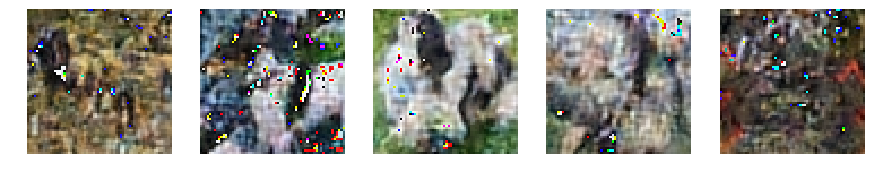

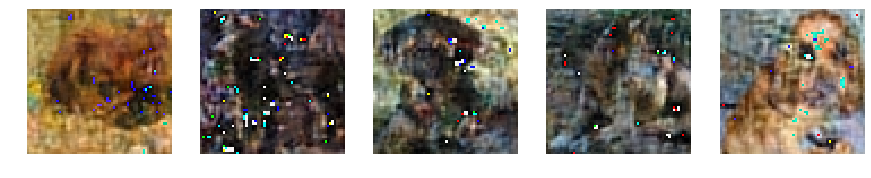

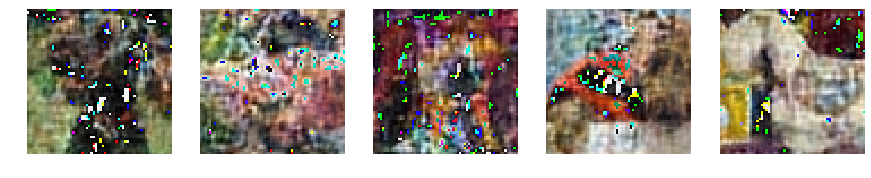

In [11]:
# DISPLAY EXAMPLE DOGS
d = DogGenerator()
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = d.getDog(np.random.normal(0,1,100))
        plt.axis('off')
        plt.imshow(img)
    plt.show() 

In [12]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
d = DogGenerator()
for k in range(10000):
    img = d.getDog(np.random.normal(0,1,100))
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()